---

# Lesson 4: Walsh-Hadamard and Bernstein&ndash;Vazirani

_course: quantum cryptography for beginners
<br>date: 30 september 2024
<br>author: burton rosenberg_

---

**This lesson discuses,**

- Walsh-Hadamard Transformation
- Formula as XOR for the W-H
- Walsh basis
- Phase Kickback
- Bernstein-Vazirani 

Included in this is some quiskit/python/jupyter examples, and the quiskit documentation.



In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, Pauli 
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from IPython.display import display, Math, HTML
import time, math
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

print(f'\nqiskit version: {qiskit.version.get_version_info()}\n')


qiskit version: 1.1.2



### I: Walsh-Hadamard Transformation

The Walsh-Hadamard Transformation is a function on qubit spaces (on any vector space) $\mathcal{H}:Q^n\rightarrow Q^n$ that
can be formed as $\mathcal{H} = H^{\otimes n}$. This is a very fascinating transformation. 

It is an involution,

$$
\mathcal{H}\cdot\mathcal{H} = H^{\otimes n}\cdot H^{\otimes n} = (H\cdot H)^{\otimes n} = \mathbb{I}^{\otimes n} = \mathbb{I}
$$

The rows and columns are all orthogonal, and the span the space. The coefficients for a general $|x\rangle$ expressed in the _Walsh basis_, the columns of the matrix, are given by applying the transformation.

Note that the Hadamard is the sum of two Pauli matrices, $H=(1/\sqrt{2})(X+Z)$. This is not a surprise as the Hadamard matrix is Hermitian and the set of Pauli's plus the identity form a four dimensitional basis over the complex numbers for the space of Hermitian matrices. But it is a particularly simple combination. 

The Hadamard is also Unitary, so we already know it's eigenvalues are from the set $\{\,1,-1\,\}$ and indeed it has one of each, according to the line of symmetry (+1) or asymetry (-1).

References: 
- [Operator class](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Operator)
- [Pauli class](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Pauli)

In [2]:
def H_n(n) :
    h = Operator(Pauli('X').to_matrix()+Pauli('Z').to_matrix())
    h_s = h.copy()
    for i in range(n-1):
        h_s = h_s.tensor(h)
    return h_s

d = 3
for i in range(d):
    display(H_n(i+1).draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



### Exercise A

Does the following communitive diagram and the universal property of the tensor product prove, using "abstract nonsense", that,
$$
(A\otimes B)\cdot(C\otimes D) = (A\cdot C)\otimes(B\cdot D)
$$
These diagrams commute,
$$
\begin{matrix}
V\times W &\xrightarrow{\otimes}&V\otimes W\\
& \\
v,w & \longrightarrow & v\otimes w&\\
\downarrow & \circlearrowleft& \downarrow &\\
Cv,Dw &\longrightarrow  &(C\otimes D)(v\otimes w) &\\
\downarrow &\circlearrowleft & \downarrow &\\
A(Cv),B(Dw) &\longrightarrow  &(A\cdot C)\otimes(B\cdot D)(v\otimes w)  &\\
\end{matrix}
$$

In [3]:
## code here


### II: Plus-Minus hack

Ryan O'Donnell in _Revealing XOR-patterns I: Lecture 11 of Quantum Computation at CMU_
talks about the plus minus hack. It imprints on state $|x\rangle$ the value of a boolean function $F(x)$
in the sign of the state,
$$
|x\rangle\mapsto (-1)^{F(x)}|x\rangle
$$
This is the global state and in this form might not show a consequence. However when applied to general 
state, a relative sign will appear on otherwise unchanged coefficients.

An _ancillary_ qubit is needed. Maybe we have not yet talked about ancillary bits. Since all quantum computation
has to be reversable, something like a simple AND cannot be represented as a quantum gate, because AND is not
invertible. There are techniques to make AND, and any function, reversable, by adding extra qubits that record 
the lost information. Since $F(x)$ is boolean, the simplest thing is to add an output qubit and to use and xor
to write $F(x)$ onto this qubit. 


The output xor gives, 
$$
|x,b\rangle\mapsto |x, b\oplus F(x)\rangle =
\begin{cases}|x, b\rangle & F(x)=0\\
|x, X\,b\rangle & F(x)=1
\end{cases}
$$
we apply this with $b$ the minus state, 
\begin{eqnarray*}
|x,-\rangle &\mapsto& \begin{cases}|x, -\rangle & F(x)=0\\
- |x,-\rangle & F(x)=1
\end{cases} \\
&=& (-1)^{F(x)}|x,-\rangle
\end{eqnarray*}
This state is not entangled.

If the $|b\rangle$ qubit is an ancillary, rather than leave it in an variable state, it is sometimes
possible to "uncompute" it, to return it to the input state. 

$$
|x,0\rangle \mapsto (-1)^{F(x)}|x,0\rangle
$$

Reference: O'Donnell's video [Revealing XOR-patterns I](https://www.youtube.com/watch?v=6TslH7ToFb8).


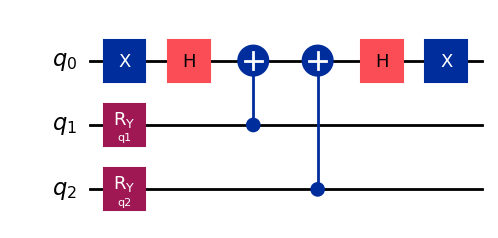

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
qc = QuantumCircuit(3)
qc.x(0)
qc.h(0)
q1_switch = Parameter('q1')
q2_switch = Parameter('q2')
qc.ry(q1_switch,1)
qc.ry(q2_switch,2)
qc.cx(1,0)
qc.cx(2,0)
qc.h(0)
qc.x(0)

#op = Operator(qc)
#display(op.draw('latex'))
#qc.measure_all()
display(qc.draw('mpl'))

params = [
    {q1_switch:0,q2_switch:0},
    {q1_switch:math.pi,q2_switch:0},
    {q1_switch:0,q2_switch:math.pi},
    {q1_switch:math.pi,q2_switch:math.pi}
]

for param in params:
    sv = Statevector(qc.assign_parameters(param))
    display(sv.draw('latex'))


### Exercise B

For some $n$ qubits, show the output of the Hadamard transformation on the number $0,1,\ldots,2^n-1$.

Create a python program that gives the columns of the Hadamard matrix using xor products, and compare the result.


In [5]:
### Exercise B





### Exercise C

Is there something for two qubits?
$$
|x,0\rangle\mapsto (i)^{F(x)}|x,0\rangle
$$


In [6]:
#### Exercise C





### Exercise D

What if the controlled X is replaced with the controlled Z? Is this a useful circuit? (I don't know.)


In [7]:
### Exercise D




### III: Bernstein-Vazirani 

The Walsh-Hadamard transformation combined with the plus-minus hack gives the Bernstein-Vazirani algorithm. 

__Puzzle:__ Given an oracle for $F_r(x) = r\odot x$, find $r$.

An _oracle_ is the idea that I can ask for $F_r(x)$ for $x$ of my choosing, but I cannot look inside the oracle
to find $r$. I have to find $r$ by trying different $x$. In this case, I can read off $r$ bit by bit by using 
$x=1,2,\ldots,2^k$.

The walsh-hadamard transformation,

$$
\mathcal{H} |i\rangle = \sum_j (-1)^{i\cdot j}\,|j\rangle
$$

We construct the oracle with c-not gates that summarize their outputs on the ancillary. When evaluted at all $|j\rangle. = \mathcal{H}\,|0\rangle$ this creates the state  $\mathcal{H}\,|r\rangle$. Another walsh-hadamard gives state $|r\rangle$ which is then measured
in the computational basis.

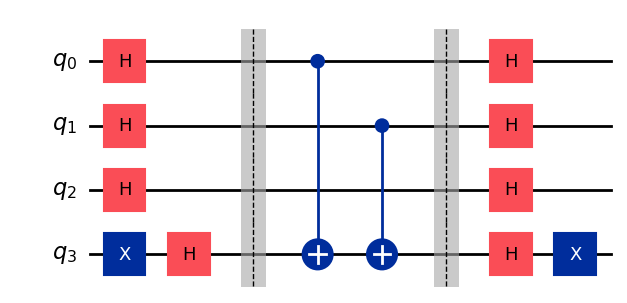

<IPython.core.display.Latex object>

In [8]:

def b_v_circuit(n,d):
    
    qc = QuantumCircuit(n+1)
    for i in range(n):
        qc.h(i)
    qc.x(n)
    qc.h(n)
    qc.barrier()

    i = 0
    while d>0:
        if d%2==1:
            qc.cx(i,3)
        i += 1
        d //= 2

    qc.barrier()
    for i in range(n):
        qc.h(i)
    qc.h(n)
    qc.x(n)

    return qc

qc = b_v_circuit(3,3)
sv_2 = Statevector(qc)
display(qc.draw('mpl'))
display(sv_2.draw('latex'))

### Exercise E

Try different xor patterns and qubits to explore that this is correct.

Is the final Hadamard (highest qubit, last applied) necessary?


In [9]:
### Exercise E





-----

## Answers to Exercises


-----

### Answer to Exercise B

In [10]:
def xor_prod(x,y):
    t = 0
    while (x*y)!=0:
        t += (x%2)*(y%2)
        x, y = x//2, y//2
    return t

def walsh_basis(n,x):
    d = [1]*n
    for i in range(n):
        d[i] = (-1)**xor_prod(x,i)
    return d

n = 8
for d in range(n):  
    print(f'{d}: {walsh_basis(n,d)}')

0: [1, 1, 1, 1, 1, 1, 1, 1]
1: [1, -1, 1, -1, 1, -1, 1, -1]
2: [1, 1, -1, -1, 1, 1, -1, -1]
3: [1, -1, -1, 1, 1, -1, -1, 1]
4: [1, 1, 1, 1, -1, -1, -1, -1]
5: [1, -1, 1, -1, -1, 1, -1, 1]
6: [1, 1, -1, -1, -1, -1, 1, 1]
7: [1, -1, -1, 1, -1, 1, 1, -1]


### Answer to Exercise C

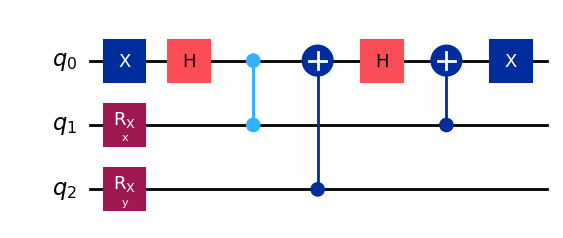

None

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [11]:
x = Parameter('x')
y = Parameter('y')

qc = QuantumCircuit(3)
qc.rx(x,1)
qc.rx(y,2)
qc.x(0)
qc.h(0)
qc.cz(1,0)
qc.cx(2,0)
qc.h(0)
qc.cx(1,0)
qc.x(0)

#op = Operator(qc)
#display(op.draw('latex'))
display(display(qc.draw('mpl')))

params = [
    {x:0, y:0},
    {x:math.pi, y:0},
    {x:0, y:math.pi},
    {x:math.pi, y:math.pi}
]

basic_sim = BasicSimulator()
for param in params:
    sv = Statevector(qc.assign_parameters(param))
    display(sv.draw('latex'))

### END